<h2>Projeto de Aprendizado de Máquina Ponta a Ponta</h2>
   <h4>Cap 02 Livro Mãos à Obra: Aprendizado de Máquina com Scikit-Learn, Keras & TensorFlow</h4>
    
Nesse projeto orientado será feita a predição de valores de imóveis utilizando uma base de dados criada a partir dos dados de senso habitacional da Califórnia em 1990.

Os dados serão baixados através de script dentro do próprio notebook, conforme código abaixo:

In [1]:
import os
import tarfile
import urllib

#vamos pegar o diretório corrente para verificar onde a base de dados será criada
cur_dir = os.getcwd()

print("Diretorio corrente:", cur_dir)

DOWNLOAD_ROOT = "https://github.com/ageron/data/raw/main/"
HOUSING_PATH = os.path.join(cur_dir, "datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    try:
        if not os.path.exists(housing_path):
            os.makedirs(housing_path, mode=0o666)
    except OSError:
        sys.exit('Fatal: output directory "' + housing_path + '" does not exist and cannot be created')
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

#chama a função para download dos dados
fetch_housing_data()

Diretorio corrente: D:\Anaconda-envs\Machine Learning


Após download realizado, vamos fazer uma análise inicial dos dados utilizando o pandas.

In [2]:
import pandas as pd

csv_path = os.path.join(HOUSING_PATH,"housing", "housing.csv")
housing_data = pd.read_csv(csv_path)

print(housing_data.head())

print(housing_data.info())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639

É possível ver que temos 20640 registros na base de dados. Apenas o atributo <font color='blue'>total_bedrooms</font> possui dados nulos (faltantes), e apenas um atributo é do tipo object, todos os demais são numéricos.
O atributo ocean_proximity, que é do tipo object, parece ser um atributo categórico. Vamos verificar quais categorias e quantos registros de cada, a partir do seguinte comando:

In [3]:
housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

As estatísticas básicas de todos os atributos numéricos podem ser vistas através do comando:

In [4]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Apesar das estatísticas básicas darem uma boa noção do comportamento dos dados, melhor seria visualizar o comportamento gráfico, através de histogramas.
Isso pode ser feito utilizando a biblioteca pyplot do matplotlib.

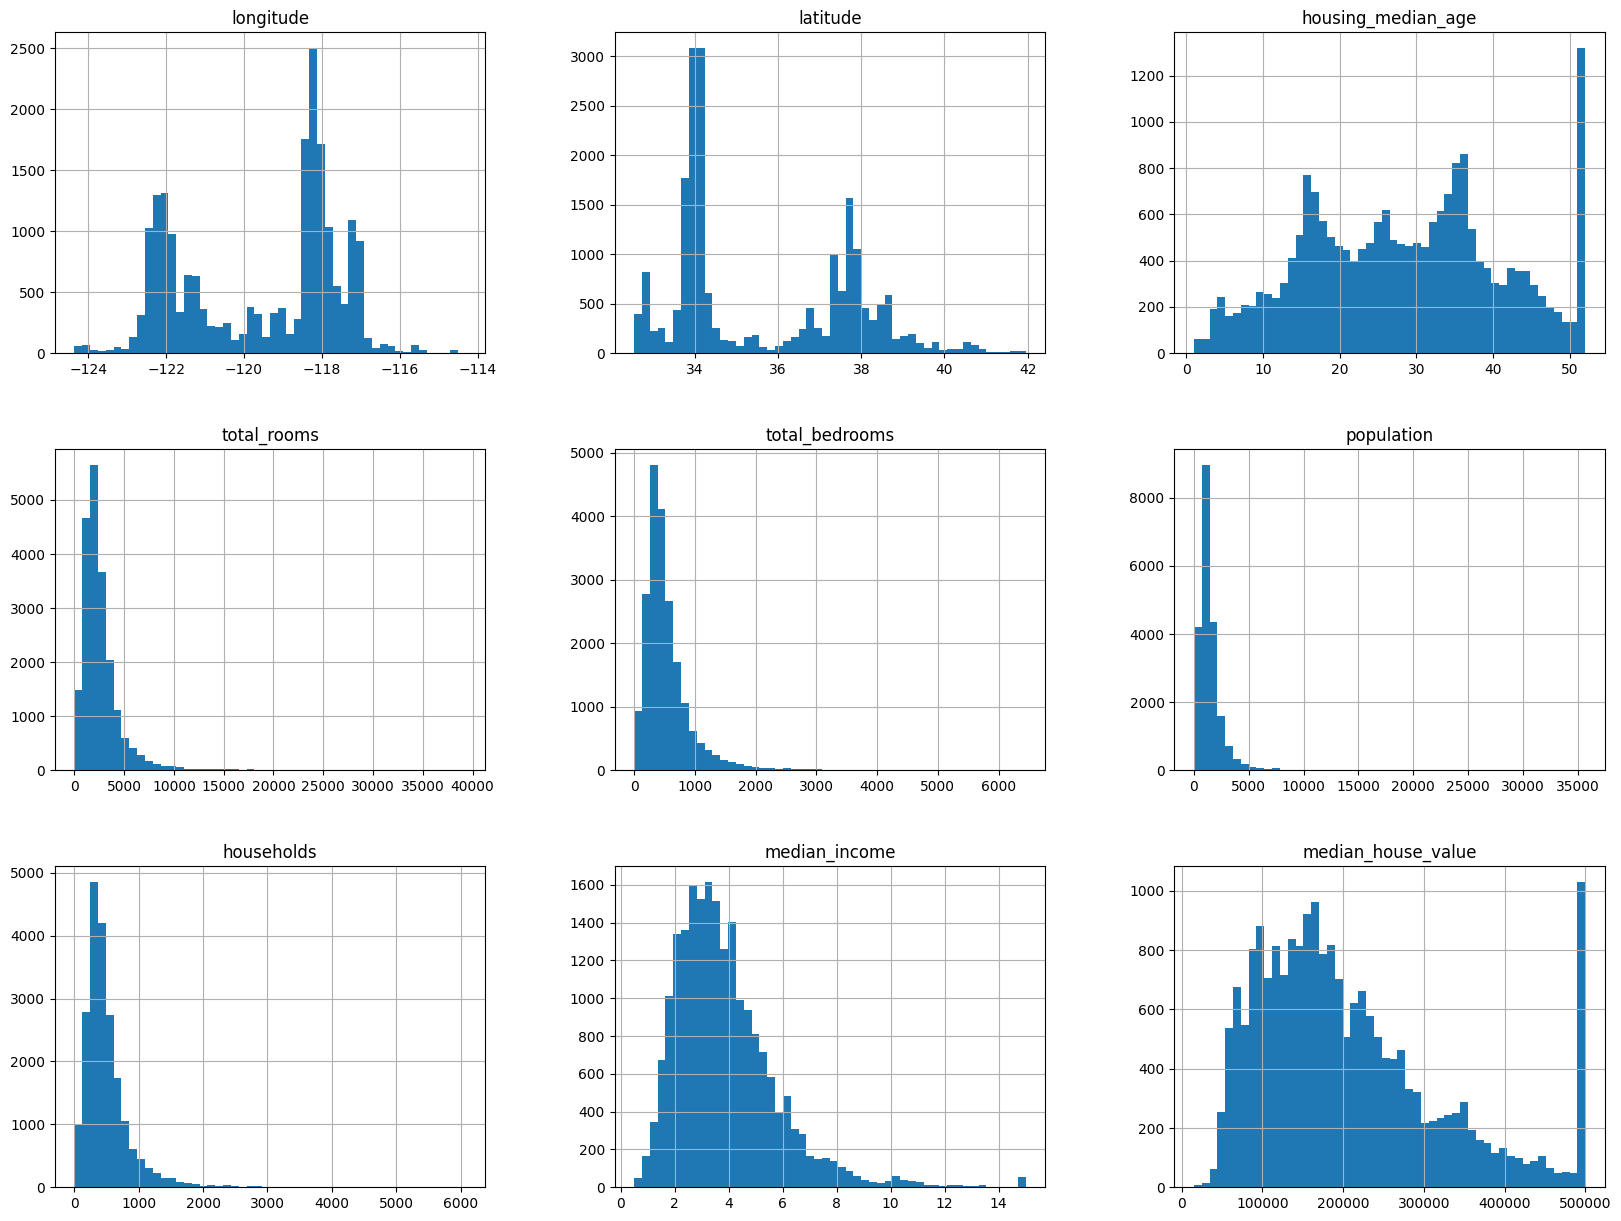

In [5]:
import matplotlib.pyplot as plt
housing_data.hist(bins=50, figsize=(20,15))
plt.show()

<h4>Estratificação dos dados de treinamento</h4>

Pode-se observar que o atributo renda média - median_income está representado em unidades de 10.000 USD. 
Considerando que esse é um atributo muito importante para estimar o preço dos imóveis, é necessário que o conjunto de treinamento represente diversas categorias de rendimentos para que o modelo não fique enviezado. Entretanto é possível observar pelo histograma que os dados disponíveis possuem uma tendência a se concentrarem mais à esquerda no gráfico, com um longa cauda à direita.
Vamos então transformar a renda média em um atributo categórico com cinco categorias de rendas rotuladas de 1 a 5, com a categoria 1 variando de 0 a 1,5 (0 - 15.000 USD), a categoria 2 variando de 1,5 a 3, e assim por diante.


<AxesSubplot: >

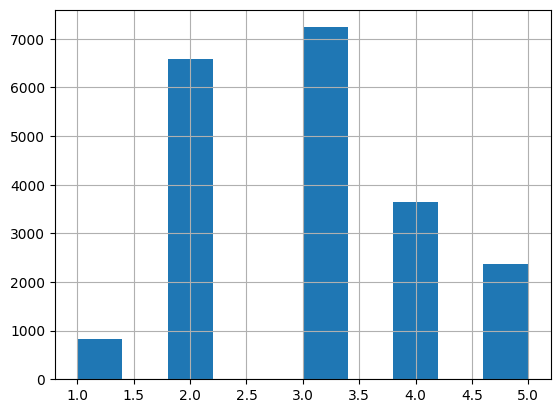

In [6]:
import numpy as np
housing_data["income_cat"] = pd.cut(housing_data["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

housing_data["income_cat"].hist()

Com essa nova característica criada é possível fazer uma amostragem estratificada por renda utilizando a seguinte função:


In [7]:
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_data, housing_data["income_cat"]):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

#em seguida a característica income_cat pode ser removida dos conjuntos de treinamento e teste

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat",axis=1, inplace=True)
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


<AxesSubplot: title={'center': 'Dispersão da longitude x latitude'}, xlabel='longitude', ylabel='latitude'>

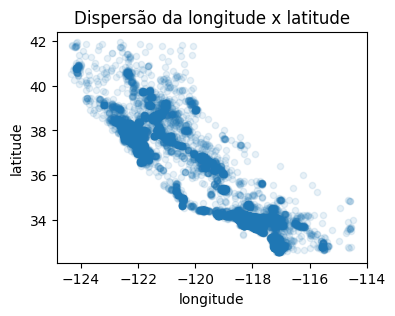

In [8]:
#vamos fazer uma cópia do conjunto de treinamento
housing_train = strat_train_set.copy()

#gráfico de dispersão das características latitude e longitude no conjunto de treinamento
housing_train.plot(kind='scatter',x='longitude',y='latitude', alpha=0.1, title='Dispersão da longitude x latitude', figsize=(4,3))

No mesmo gráfico de dispersão é possível plotar as informações de população e preço médio. Podemos utilizar o raio de cada círculo como indicador da população e uma escala de cores para indicar o preço médio. Isso pode ser feito através dos parâmetros <font color='blue'>s</font> e <font color='blue'>c</font> da função <font color='blue'>plot</font>.

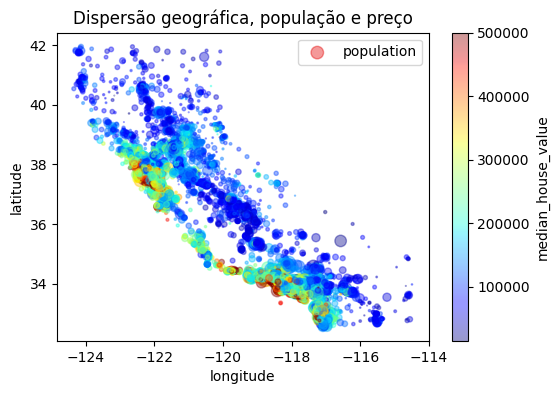

In [9]:
import matplotlib.pyplot as plt
housing_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing_train['population']/100, label='population',
                  figsize=(6,4), c='median_house_value', cmap=plt.get_cmap('jet'),colorbar=True, title='Dispersão geográfica, população e preço')
plt.legend()

<h4>Buscando Correlações</h4>

Como o conjunto de dados não é muito grande vamos calcular o coeficiente de correlação padrão (r de Pearson) entre cada par de atributos utilizando o método <font color='blue'>corr()</font>.

Vamos utilizar a biblioteca Seaborn para visualizar o mapa de calor dos coeficientes de correlação. E também vamos ver os atributos que possuem maior correlação com o atributo alvo de predição: <font color='blue'>median_house_value</font>.

C:\Users\deric\AppData\Local\Temp\ipykernel_2904\3940886433.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_train.corr()


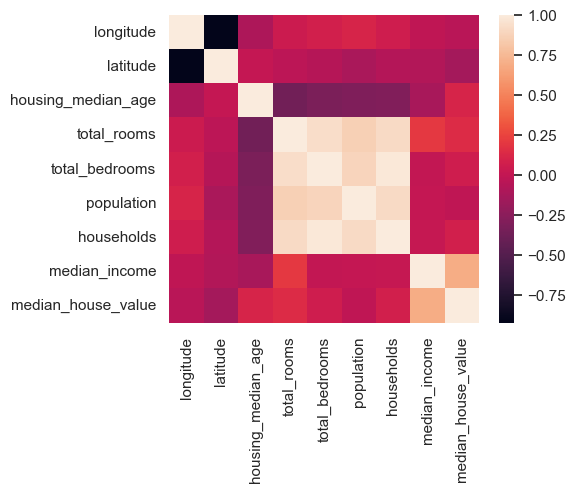

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


In [10]:
import seaborn as sns

corr_matrix = housing_train.corr()

sns.set()

plt.figure(figsize=(5,4))
ax = sns.heatmap(corr_matrix)
plt.show()

print(corr_matrix["median_house_value"].sort_values(ascending=False))

Vamos ver como os atributos mais correlacionados com o <font color='blue'>median_house_value</font> se comportam graficamente.


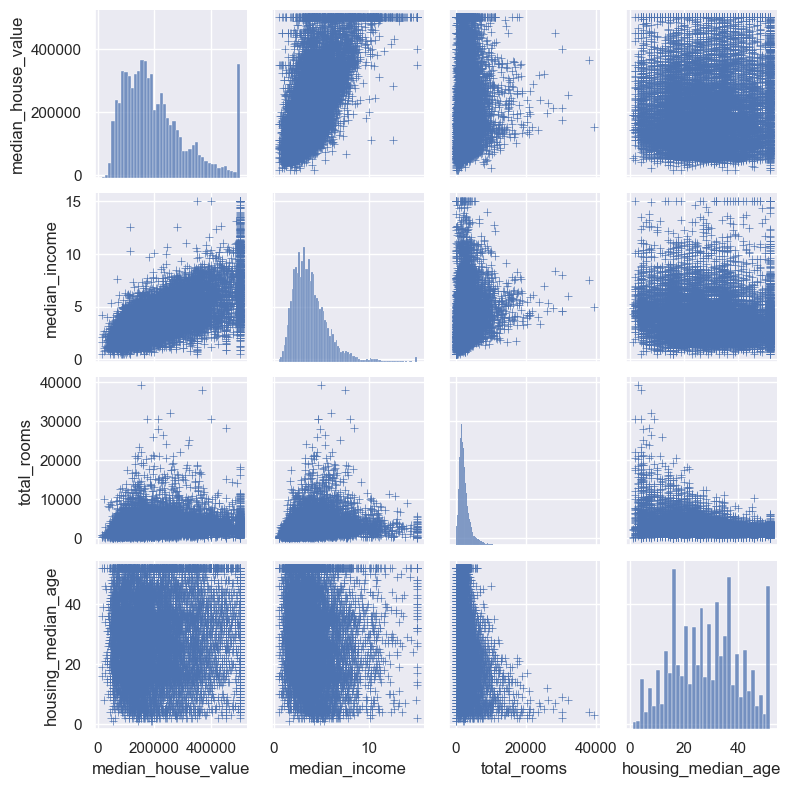

In [11]:
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
sns.pairplot(housing_train[attributes], markers='+', height=2)

Vamos criar novos atributos dados pela:
<ul>
    <li>Relação entre número de cômodos e número de famílias (ou ocupantes).</li>
    <li>Relação entre número de quartos e número de cômodos.</li>
    <li>Relação entre população e número de famílias.</li>
</ul>

E depois vamos analisar quais os coeficientes de correlação com relação ao atributo alvo <font color='blue'>median_house_value</font> considerando esses novos atributos.

In [12]:
housing_train['rooms_per_household']=housing_train['total_rooms']/housing_train['households']
housing_train['bedrooms_per_rooms']=housing_train['total_bedrooms']/housing_train['total_rooms']
housing_train['population_per_household']=housing_train['population']/housing_train['households']

corr_matrix = housing_train.corr()
print(corr_matrix['median_house_value'].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_rooms         -0.256397
Name: median_house_value, dtype: float64


C:\Users\deric\AppData\Local\Temp\ipykernel_2904\1944490355.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_train.corr()


É possível ver que a razão de quartos por cômodos está mais correlacionada com o valor médio das casas do que a quantidade de cômodos e a quantidade de quartos separadamente. É uma correlação negativa, significando que quanto menor a razão quartos/cômodos maior o valor da casa.

A razão de número de cômodos por famílias também tem maior correlação com o preço médio das casas se comparado com o número de cômodos e número de famílias separadamente.

<h3>Preparando os Dados para Algoritmos</h3>

A primeira etapa na preparação dos dados é lidar com dados faltantes ou null.
Para realizar o preenchimento de dados ausentes, pode-se utlizar a classe <font color='blue'>SimpleImputer</font> do Scikit-Learn. Apenas o atributo <font color='blue'>total_bedrooms</font> possui valores faltantes, e vamos preenchê-los com a média deste atributo.

Iniciamos separando o atributo alvo do restante do conjunto de treinamento, e depois vamos separar as variáveis númericas das categóricas (no caso, apenas a <font color='blue'>ocean_proximity</font> é categórica). A codificação das categorias pode ser feita de diversas formas, por exemplo usando a classe <font color='blue'>OrdinalEncoder</font> que atribui um valor inteiro para cada categoria, ou a classe <font color='blue'>OneHotEncoder</font> que realiza uma codificação distribuída onde cada categoria se torna um novo atributo com valores binários (Ambas são classes do Scikit-Learn).

O problema da codificação ordinária é que o algoritmo podem assumir erroneamente que valores próximos numericamente sejam mais semelhantes, o que nem sempre é verdade.

E por fim iremos criar um transformador para criar os atributos combinados que estudamos anteriormente. Para que um transformador customizado funcione com o Scikit-Learn é necessário criar uma classe com os seguintes métodos: fit(), self e fit_transform(). Para atender esses requisitos o Scikit-Learn disponibiliza duas classes base que devemos usar para que nosso transformador herde esses métodos: <font color='blue'>TransformerMixin</font> e <font color='blue'>BaseEstimator</font>.


In [13]:
housing_train = strat_train_set.drop("median_house_value", axis=1)
housing_train_labels = strat_train_set["median_house_value"].copy()

#características numéricas
housing_train_num = housing_train.drop('ocean_proximity', axis=1)
#características categóricas
housing_train_cat = housing_train[['ocean_proximity']]

#preenchimento de valores faltantes com a média
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
imputer.fit(housing_train_num)
print('Estatísticas do modelo: ', imputer.statistics_)
#a classe possui um método transform que retorna um NumPy array com as características transformadas
X = imputer.transform(housing_train_num)
housing_train_new = pd.DataFrame(X, columns=housing_train_num.columns, index=housing_train_num.index)

print(housing_train_new.info())

#codificação one-hot do atributo categórico
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_train_cat)
print(housing_cat_1hot)

#customizando um transformador para criação de novos atributos
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self #o método fit não faz nada no nosso transformador
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_train.values)



Estatísticas do modelo:  [-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB
None
  (0, 3)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 4)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 3)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 4)	1.0
  (15, 0)	1.0
  (16, 1)	1.0
  (17, 3)	1.0
  (18, 

Para finalizar a etapa de preparação dos dados, vamos criar um pipeline utilizando todos os transformadores acima, mais um escalonador padronizador - <font color='blue'>StandardEscaler</font>. Utilizaremos também uma classe do Scikit-Learn chamada <font color='blue'>ColumnTransformer</font> que permite transformar simultaneamente as características numéricas e categóricas.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#pipeline para tratar os atributos numéricos
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_train_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_train_prepared = full_pipeline.fit_transform(housing_train)

housing_train_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

<h4>Treinando um modelo</h4>

Para finalizar o processo de ponta a ponta, vamos treinar um modelo Random Forest para realizar a predição do preço de venda.
Além disso, utilizaremos grid search e cross validation para encontrar melhores hiperparâmetros pro modelo considerando a validação cruzada do modelo com os dados de treinamento divididos em N dobras (cada dobra é utilizada para treinar o modelo que é validado com os dados fora da dobra).

Random Forest é um modelo ensemble (modelo agrupado ou agregado) de árvores de decisão.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10], 'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_train_prepared, housing_train_labels)

print(grid_search.best_params_)

print(grid_search.best_estimator_)

{'max_features': 6, 'n_estimators': 30}
RandomForestRegressor(max_features=6, n_estimators=30)


In [33]:
from sklearn.metrics import mean_squared_error
housing_test = strat_test_set.drop("median_house_value", axis=1)
housing_test_labels = strat_test_set["median_house_value"].copy()
housing_test_prepared = full_pipeline.transform(housing_test)

preds = grid_search.predict(housing_test_prepared)
print('Mean Squared Error for validation dataset:', np.sqrt(mean_squared_error(housing_test_labels.values, preds.ravel())))

Mean Squared Error for validation dataset: 49779.206303212944
